### Question 1. Log Mining and Analysis [15 marks] 
You need to finish Lab 1 and Lab 2 before solving this question.
Data: Use wget to download the NASA access log July 1995 data (using the hyperlink ftp://ita.ee.lbl.gov/traces/NASA_access_log_Jul95.gz) to the “Data” folder. The data description is the same as in Lab 2 Task 4 Question 1 so please review it to understand the data before completing the four tasks below.  

* #### A.	Find out the maximum number and minimum number of requests on each of the seven days in a week (i.e., Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, and Sunday) during July 1995. You need to report 14 numbers, one max number and one min number for each day of the week. Hint: see pyspark sql API related to data format. [4 marks]

* #### B.	Visualise the 14 numbers in A above in ONE figure to help gain insights from them [2 marks]

* #### C.	Find out the 12 most requested and 12 least requested .mpg videos. Report the video file name, e.g. abc.mpg, and the total number of requests for each of these 24 videos during July 1995. [4 marks]

* #### D.	Visualise the 24 total request numbers in C as ONE figure to help gain insights from them [2 marks] 

* #### E.	Discuss two most interesting observations from A to D above, each with three sentences: 1) What is the observation? 2) What are the possible causes of the observation? 3) How useful is this observation to NASA? [2 marks]

* #### F.	Your report must be clearly written and your code must be well documented so that it is clear what each step is doing. [1 mark]


In [1]:
import pyspark
from pyspark.sql import SparkSession
import re
import pandas as pd



spark = SparkSession.Builder().master("local[6]").appName("Scalab_Q1_Part2").config("spark.local.dir","C:\temp").getOrCreate()



In [2]:
import matplotlib 
matplotlib.use('Agg') # Must be before importing matplotlib.pyplot or pylab! 
import matplotlib.pyplot as plt


In [3]:
m = re.finditer(r'.*?(spark).*?', "I'm searching for a spark in PySpark", re.I)
for match in m:
    print(match, match.start(), match.end())

<re.Match object; span=(0, 25), match="I'm searching for a spark"> 0 25
<re.Match object; span=(25, 36), match=' in PySpark'> 25 36


In [4]:
import pyspark.sql.functions as F

logFile = spark.read.text("NASA_access_log_Jul95.gz").cache()  # add it to cache, so it can be used in the following steps efficiently      
# logFile.show(20, False)



In [5]:
type(logFile)
# logFile.printSchema()

pyspark.sql.dataframe.DataFrame

In [6]:
logFile_rdd = logFile.rdd
type(logFile_rdd)

pyspark.rdd.RDD

In [7]:
logFile.show(20, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                         |
+------------------------------------------------------------------------------------------------------------------------------+
|199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245                                        |
|unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985                             |
|199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085          |
|burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0                      |
|199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small

In [8]:
# logFile_rdd.take(20)

In [9]:
print((logFile.count(), len(logFile.columns)))

(1891715, 1)


In [10]:
sample_logs = [item['value'] for item in logFile.take(15)]
sample_logs

['199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245',
 'unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985',
 '199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085',
 'burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0',
 '199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179',
 'burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /images/NASA-logosmall.gif HTTP/1.0" 304 0',
 'burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/video/livevideo.gif HTTP/1.0" 200 0',
 '205.212.115.106 - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/countdown.html HTTP/1.0" 200 3985',
 'd104.aa.net - - [01/Jul/1995:00:00:13 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985',
 '129.94.144.152 - - [01/Jul/

In [11]:
host_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
hosts = [re.search(host_pattern, item).group(1)
           if re.search(host_pattern, item)
           else 'no match'
           for item in sample_logs]
hosts

['199.72.81.55',
 'unicomp6.unicomp.net',
 '199.120.110.21',
 'burger.letters.com',
 '199.120.110.21',
 'burger.letters.com',
 'burger.letters.com',
 '205.212.115.106',
 'd104.aa.net',
 '129.94.144.152',
 'unicomp6.unicomp.net',
 'unicomp6.unicomp.net',
 'unicomp6.unicomp.net',
 'd104.aa.net',
 'd104.aa.net']

In [12]:
ts_pattern = r'\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})]'
timestamps = [re.search(ts_pattern, item).group(1) for item in sample_logs]
timestamps

['01/Jul/1995:00:00:01 -0400',
 '01/Jul/1995:00:00:06 -0400',
 '01/Jul/1995:00:00:09 -0400',
 '01/Jul/1995:00:00:11 -0400',
 '01/Jul/1995:00:00:11 -0400',
 '01/Jul/1995:00:00:12 -0400',
 '01/Jul/1995:00:00:12 -0400',
 '01/Jul/1995:00:00:12 -0400',
 '01/Jul/1995:00:00:13 -0400',
 '01/Jul/1995:00:00:13 -0400',
 '01/Jul/1995:00:00:14 -0400',
 '01/Jul/1995:00:00:14 -0400',
 '01/Jul/1995:00:00:14 -0400',
 '01/Jul/1995:00:00:15 -0400',
 '01/Jul/1995:00:00:15 -0400']

In [13]:
method_uri_protocol_pattern = r'\"(\S+)\s(\S+)\s*(\S*)\"'
method_uri_protocol = [re.search(method_uri_protocol_pattern, item).groups()
               if re.search(method_uri_protocol_pattern, item)
               else 'no match'
              for item in sample_logs]
method_uri_protocol

[('GET', '/history/apollo/', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/', 'HTTP/1.0'),
 ('GET', '/shuttle/missions/sts-73/mission-sts-73.html', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/liftoff.html', 'HTTP/1.0'),
 ('GET', '/shuttle/missions/sts-73/sts-73-patch-small.gif', 'HTTP/1.0'),
 ('GET', '/images/NASA-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/video/livevideo.gif', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/countdown.html', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/', 'HTTP/1.0'),
 ('GET', '/', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/count.gif', 'HTTP/1.0'),
 ('GET', '/images/NASA-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/images/KSC-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/count.gif', 'HTTP/1.0'),
 ('GET', '/images/NASA-logosmall.gif', 'HTTP/1.0')]

In [14]:
status_pattern = r'\s(\d{3})\s'
status = [re.search(status_pattern, item).group(1) for item in sample_logs]
print(status)

['200', '200', '200', '304', '200', '304', '200', '200', '200', '200', '200', '200', '200', '200', '200']


In [15]:
content_size_pattern = r'\s(\d+)$'
content_size = [re.search(content_size_pattern, item).group(1) for item in sample_logs]
print(content_size)

['6245', '3985', '4085', '0', '4179', '0', '0', '3985', '3985', '7074', '40310', '786', '1204', '40310', '786']


In [16]:
from pyspark.sql.functions import regexp_extract

logs_df = logFile.select(regexp_extract('value', host_pattern, 1).alias('host'),
                         regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                         regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                         regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                         regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                         regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                         regexp_extract('value', content_size_pattern, 1).cast('integer').alias('content_size'))
logs_df.show(20, truncate=True)
print((logs_df.count(), len(logs_df.columns)))

+--------------------+--------------------+------+--------------------+--------+------+------------+
|                host|           timestamp|method|            endpoint|protocol|status|content_size|
+--------------------+--------------------+------+--------------------+--------+------+------------+
|        199.72.81.55|01/Jul/1995:00:00...|   GET|    /history/apollo/|HTTP/1.0|   200|        6245|
|unicomp6.unicomp.net|01/Jul/1995:00:00...|   GET| /shuttle/countdown/|HTTP/1.0|   200|        3985|
|      199.120.110.21|01/Jul/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        4085|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/shuttle/countdow...|HTTP/1.0|   304|           0|
|      199.120.110.21|01/Jul/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        4179|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/images/NASA-logo...|HTTP/1.0|   304|           0|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/shuttle/countdow...|HTTP/1.0|   200|    

In [17]:
(logFile
    .filter(logFile['value']
                .isNull())
    .count())

0

In [18]:


bad_rows_df = logs_df.filter(logs_df['host'].isNull()| 
                             logs_df['timestamp'].isNull() | 
                             logs_df['method'].isNull() |
                             logs_df['endpoint'].isNull() |
                             logs_df['status'].isNull() |
                             logs_df['content_size'].isNull()|
                             logs_df['protocol'].isNull())
bad_rows_df.count()



19727

In [19]:
logs_df.columns

['host',
 'timestamp',
 'method',
 'endpoint',
 'protocol',
 'status',
 'content_size']

In [20]:
from pyspark.sql.functions import col
from pyspark.sql.functions import sum as spark_sum

def count_null(col_name):
    return spark_sum(col(col_name).isNull().cast('integer')).alias(col_name)

# Build up a list of column expressions, one per column.
exprs = [count_null(col_name) for col_name in logs_df.columns]

# Run the aggregation. The *exprs converts the list of expressions into
# variable function arguments.
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     1|       19727|
+----+---------+------+--------+--------+------+------------+



Note: In the expression below, ~ means "not".

In [21]:
null_status_df = logFile.filter(~logFile['value'].rlike(r'\s(\d{3})\s'))
null_status_df.count()

1

In [22]:
null_status_df.show(truncate=False)

+--------+
|value   |
+--------+
|alyssa.p|
+--------+



In [23]:


bad_status_df = null_status_df.select(regexp_extract('value', host_pattern, 1).alias('host'),
                                      regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                                      regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                                      regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                                      regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                                      regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                                      regexp_extract('value', content_size_pattern, 1).cast('integer').alias('content_size'))
bad_status_df.show(truncate=False)



+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|    |         |      |        |        |null  |null        |
+----+---------+------+--------+--------+------+------------+



In [24]:
logs_df.count()

1891715

In [25]:
logs_df = logs_df[logs_df['status'].isNotNull()] 
logs_df.count()

1891714

In [26]:
exprs = [count_null(col_name) for col_name in logs_df.columns]
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|       19726|
+----+---------+------+--------+--------+------+------------+



In [27]:
null_content_size_df = logFile.filter(~logFile['value'].rlike(r'\s\d+$'))
null_content_size_df.count()

19727

In [28]:
null_content_size_df.take(10)

[Row(value='dd15-062.compuserve.com - - [01/Jul/1995:00:01:12 -0400] "GET /news/sci.space.shuttle/archive/sci-space-shuttle-22-apr-1995-40.txt HTTP/1.0" 404 -'),
 Row(value='dynip42.efn.org - - [01/Jul/1995:00:02:14 -0400] "GET /software HTTP/1.0" 302 -'),
 Row(value='ix-or10-06.ix.netcom.com - - [01/Jul/1995:00:02:40 -0400] "GET /software/winvn HTTP/1.0" 302 -'),
 Row(value='ix-or10-06.ix.netcom.com - - [01/Jul/1995:00:03:24 -0400] "GET /software HTTP/1.0" 302 -'),
 Row(value='link097.txdirect.net - - [01/Jul/1995:00:05:06 -0400] "GET /shuttle HTTP/1.0" 302 -'),
 Row(value='ix-war-mi1-20.ix.netcom.com - - [01/Jul/1995:00:05:13 -0400] "GET /shuttle/missions/sts-78/news HTTP/1.0" 302 -'),
 Row(value='ix-war-mi1-20.ix.netcom.com - - [01/Jul/1995:00:05:58 -0400] "GET /shuttle/missions/sts-72/news HTTP/1.0" 302 -'),
 Row(value='netport-27.iu.net - - [01/Jul/1995:00:10:19 -0400] "GET /pub/winvn/readme.txt HTTP/1.0" 404 -'),
 Row(value='netport-27.iu.net - - [01/Jul/1995:00:10:28 -0400] "GET

In [29]:
logs_df = logs_df.na.fill({'content_size': 0})

In [30]:
exprs = [count_null(col_name) for col_name in logs_df.columns]
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|           0|
+----+---------+------+--------+--------+------+------------+



In [31]:
from pyspark.sql.functions import udf

month_map = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12
}

def parse_clf_time(text):
    """ Convert Common Log time format into a Python datetime object
    Args:
        text (str): date and time in Apache time format [dd/mmm/yyyy:hh:mm:ss (+/-)zzzz]
    Returns:
        a string suitable for passing to CAST('timestamp')
    """
    # NOTE: We're ignoring the time zones here, might need to be handled depending on the problem you are solving
    return "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(
      int(text[7:11]),
      month_map[text[3:6]],
      int(text[0:2]),
      int(text[12:14]),
      int(text[15:17]),
      int(text[18:20])
    )

In [32]:


sample_ts = [item['timestamp'] for item in logs_df.select('timestamp').take(10)]
sample_ts



['01/Jul/1995:00:00:01 -0400',
 '01/Jul/1995:00:00:06 -0400',
 '01/Jul/1995:00:00:09 -0400',
 '01/Jul/1995:00:00:11 -0400',
 '01/Jul/1995:00:00:11 -0400',
 '01/Jul/1995:00:00:12 -0400',
 '01/Jul/1995:00:00:12 -0400',
 '01/Jul/1995:00:00:12 -0400',
 '01/Jul/1995:00:00:13 -0400',
 '01/Jul/1995:00:00:13 -0400']

In [33]:


[parse_clf_time(item) for item in sample_ts]



['1995-07-01 00:00:01',
 '1995-07-01 00:00:06',
 '1995-07-01 00:00:09',
 '1995-07-01 00:00:11',
 '1995-07-01 00:00:11',
 '1995-07-01 00:00:12',
 '1995-07-01 00:00:12',
 '1995-07-01 00:00:12',
 '1995-07-01 00:00:13',
 '1995-07-01 00:00:13']

In [34]:


udf_parse_time = udf(parse_clf_time)

logs_df = logs_df.select('*', udf_parse_time(logs_df['timestamp']).cast('timestamp').alias('time')).drop('timestamp')
logs_df.show(10, truncate=True)



+--------------------+------+--------------------+--------+------+------------+-------------------+
|                host|method|            endpoint|protocol|status|content_size|               time|
+--------------------+------+--------------------+--------+------+------------+-------------------+
|        199.72.81.55|   GET|    /history/apollo/|HTTP/1.0|   200|        6245|1995-07-01 00:00:01|
|unicomp6.unicomp.net|   GET| /shuttle/countdown/|HTTP/1.0|   200|        3985|1995-07-01 00:00:06|
|      199.120.110.21|   GET|/shuttle/missions...|HTTP/1.0|   200|        4085|1995-07-01 00:00:09|
|  burger.letters.com|   GET|/shuttle/countdow...|HTTP/1.0|   304|           0|1995-07-01 00:00:11|
|      199.120.110.21|   GET|/shuttle/missions...|HTTP/1.0|   200|        4179|1995-07-01 00:00:11|
|  burger.letters.com|   GET|/images/NASA-logo...|HTTP/1.0|   304|           0|1995-07-01 00:00:12|
|  burger.letters.com|   GET|/shuttle/countdow...|HTTP/1.0|   200|           0|1995-07-01 00:00:12|


In [35]:


logs_df.printSchema()



root
 |-- host: string (nullable = true)
 |-- method: string (nullable = true)
 |-- endpoint: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- status: integer (nullable = true)
 |-- content_size: integer (nullable = false)
 |-- time: timestamp (nullable = true)



In [36]:


logs_df.limit(10).toPandas()



,host,method,endpoint,protocol,status,content_size,time
0,199.72.81.55,GET,/history/apollo/,HTTP/1.0,200,6245,1995-07-01 00:00:01
1,unicomp6.unicomp.net,GET,/shuttle/countdown/,HTTP/1.0,200,3985,1995-07-01 00:00:06
2,199.120.110.21,GET,/shuttle/missions/sts-73/mission-sts-73.html,HTTP/1.0,200,4085,1995-07-01 00:00:09
3,burger.letters.com,GET,/shuttle/countdown/liftoff.html,HTTP/1.0,304,0,1995-07-01 00:00:11
4,199.120.110.21,GET,/shuttle/missions/sts-73/sts-73-patch-small.gif,HTTP/1.0,200,4179,1995-07-01 00:00:11
5,burger.letters.com,GET,/images/NASA-logosmall.gif,HTTP/1.0,304,0,1995-07-01 00:00:12
6,burger.letters.com,GET,/shuttle/countdown/video/livevideo.gif,HTTP/1.0,200,0,1995-07-01 00:00:12
7,205.212.115.106,GET,/shuttle/countdown/countdown.html,HTTP/1.0,200,3985,1995-07-01 00:00:12
8,d104.aa.net,GET,/shuttle/countdown/,HTTP/1.0,200,3985,1995-07-01 00:00:13
9,129.94.144.152,GET,/,HTTP/1.0,200,7074,1995-07-01 00:00:13


In [37]:


logs_df.cache()



DataFrame[host: string, method: string, endpoint: string, protocol: string, status: int, content_size: int, time: timestamp]

In [53]:
total_daily_reqests_df = (logs_df.select(F.dayofmonth("time")
                                          .alias("day"))
                              .groupBy("day")
                              .count()
                              .sort("day")
                              .select(col("day"), 
                                      col("count").alias("total_reqs")))

total_daily_reqests_df.cache()

total_daily_reqests_df.show(30,truncate=False)



+---+----------+
|day|total_reqs|
+---+----------+
|1  |64714     |
|2  |60265     |
|3  |89584     |
|4  |70452     |
|5  |94575     |
|6  |100960    |
|7  |87233     |
|8  |38867     |
|9  |35272     |
|10 |72860     |
|11 |80407     |
|12 |92536     |
|13 |134203    |
|14 |84103     |
|15 |45532     |
|16 |47854     |
|17 |74981     |
|18 |64282     |
|19 |72738     |
|20 |66593     |
|21 |64629     |
|22 |35267     |
|23 |39199     |
|24 |64259     |
|25 |62699     |
|26 |58849     |
|27 |61680     |
|28 |27121     |
+---+----------+



In [39]:
daily_hosts_df = total_daily_reqests_df.toPandas()
daily_hosts_df

,day,total_reqs
0,1,64714
1,2,60265
2,3,89584
3,4,70452
4,5,94575
5,6,100960
6,7,87233
7,8,38867
8,9,35272
9,10,72860


In [40]:
Sat_ids = [1,8,15,22]
Sun_ids = [2,9,16,23]
Mond_ids =[3,10,17,24]
Tues_ids = [4,11,18,25]
Wed_ids =[5,12,19,26]
Thur_ids =[6,13,20,27]
Fri_ids=[7,14,21,28]

# Weel_df

Saturdays_df = total_daily_reqests_df.filter((total_daily_reqests_df["day"].isin(Sat_ids)))

Sundays_df = total_daily_reqests_df.filter((total_daily_reqests_df["day"].isin(Sun_ids)))

Mondays_df = total_daily_reqests_df.filter((total_daily_reqests_df["day"].isin(Mond_ids)))

Tuesdays_df = total_daily_reqests_df.filter((total_daily_reqests_df["day"].isin(Tues_ids)))

Wednesdays_df = total_daily_reqests_df.filter((total_daily_reqests_df["day"].isin(Wed_ids)))

Thursdays_df = total_daily_reqests_df.filter((total_daily_reqests_df["day"].isin(Thur_ids)))

Fridays_df = total_daily_reqests_df.filter((total_daily_reqests_df["day"].isin(Fri_ids)))

In [41]:
Saturdays_df=(Saturdays_df.withColumnRenamed("day","Saturdays"))
Saturdays_df.show()

Sundays_df=(Sundays_df.withColumnRenamed("day","Sundays"))
Sundays_df.show()

Mondays_df=(Mondays_df.withColumnRenamed("day","Mondays"))
Mondays_df.show()

Tuesdays_df=(Tuesdays_df.withColumnRenamed("day","Tuesdays"))
Tuesdays_df.show()

Wednesdays_df=(Wednesdays_df.withColumnRenamed("day","Wednesdays"))
Wednesdays_df.show()

Thursdays_df=(Thursdays_df.withColumnRenamed("day","Thursdays"))
Thursdays_df.show()

Fridays_df=(Fridays_df.withColumnRenamed("day","Fridays"))
Fridays_df.show()    

+---------+----------+
|Saturdays|total_reqs|
+---------+----------+
|        1|     64714|
|        8|     38867|
|       15|     45532|
|       22|     35267|
+---------+----------+

+-------+----------+
|Sundays|total_reqs|
+-------+----------+
|      2|     60265|
|      9|     35272|
|     16|     47854|
|     23|     39199|
+-------+----------+

+-------+----------+
|Mondays|total_reqs|
+-------+----------+
|      3|     89584|
|     10|     72860|
|     17|     74981|
|     24|     64259|
+-------+----------+

+--------+----------+
|Tuesdays|total_reqs|
+--------+----------+
|       4|     70452|
|      11|     80407|
|      18|     64282|
|      25|     62699|
+--------+----------+

+----------+----------+
|Wednesdays|total_reqs|
+----------+----------+
|         5|     94575|
|        12|     92536|
|        19|     72738|
|        26|     58849|
+----------+----------+

+---------+----------+
|Thursdays|total_reqs|
+---------+----------+
|        6|    100960|
|       13|    

In [42]:
# total_daily_reqests_df.select(total_daily_reqests_df["total_reqs"],(max("total_reqs")))


#USE WITH COL NEED IDENTICALS
# df_concat = sat_max.union(sat_min)
# df_concat.show()

# avg_daily_reqests_per_host_df = (avg_daily_reqests_per_host_df
#                                     .withColumn('avg_reqs', col('total_reqs') / col('total_hosts'))
#                                     .sort("day"))    

In [43]:
sat_max = Saturdays_df.agg({'total_reqs': 'max'})
sat_min = Saturdays_df.agg({'total_reqs': 'min'})
 
sat_max.show()
sat_min.show() 
 
sun_max = Sundays_df.agg({'total_reqs': 'max'})
sun_min = Sundays_df.agg({'total_reqs': 'min'})

sun_max.show()
sun_min.show() 
 
mon_max = Mondays_df.agg({'total_reqs': 'max'})
mon_min = Mondays_df.agg({'total_reqs': 'min'})
 
mon_max.show()
mon_min.show() 
 
 
tue_max = Tuesdays_df.agg({'total_reqs': 'max'})
tue_min = Tuesdays_df.agg({'total_reqs': 'min'})
 
tue_max.show()
tue_min.show() 
 
 
wed_max = Wednesdays_df.agg({'total_reqs': 'max'})
wed_min = Wednesdays_df.agg({'total_reqs': 'min'})
 
wed_max.show()
wed_min.show() 
 
 
thur_max = Thursdays_df.agg({'total_reqs': 'max'})
thur_min = Thursdays_df.agg({'total_reqs': 'min'})
 
thur_max.show()
thur_min.show() 
 
 
fri_max = Fridays_df.agg({'total_reqs': 'max'})
fri_min = Fridays_df.agg({'total_reqs': 'min'})

 
fri_max.show()
fri_min.show() 
 

+---------------+
|max(total_reqs)|
+---------------+
|          64714|
+---------------+

+---------------+
|min(total_reqs)|
+---------------+
|          35267|
+---------------+

+---------------+
|max(total_reqs)|
+---------------+
|          60265|
+---------------+

+---------------+
|min(total_reqs)|
+---------------+
|          35272|
+---------------+

+---------------+
|max(total_reqs)|
+---------------+
|          89584|
+---------------+

+---------------+
|min(total_reqs)|
+---------------+
|          64259|
+---------------+

+---------------+
|max(total_reqs)|
+---------------+
|          80407|
+---------------+

+---------------+
|min(total_reqs)|
+---------------+
|          62699|
+---------------+

+---------------+
|max(total_reqs)|
+---------------+
|          94575|
+---------------+

+---------------+
|min(total_reqs)|
+---------------+
|          58849|
+---------------+

+---------------+
|max(total_reqs)|
+---------------+
|         134203|
+---------------+


In [44]:
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql import Window

minimals = mon_min
minimals.show()

minimals = minimals.union(tue_min).union(wed_min).union(thur_min).union(fri_min).union(sat_min).union(sun_min)
minimals.show()

minimals = minimals.withColumn("Mon-Sun", row_number().over(Window.orderBy(monotonically_increasing_id())))
minimals.show()

+---------------+
|min(total_reqs)|
+---------------+
|          64259|
+---------------+

+---------------+
|min(total_reqs)|
+---------------+
|          64259|
|          62699|
|          58849|
|          61680|
|          27121|
|          35267|
|          35272|
+---------------+

+---------------+-------+
|min(total_reqs)|Mon-Sun|
+---------------+-------+
|          64259|      1|
|          62699|      2|
|          58849|      3|
|          61680|      4|
|          27121|      5|
|          35267|      6|
|          35272|      7|
+---------------+-------+



In [45]:
maximals = mon_max
maximals.show()

maximals = maximals.union(tue_max).union(wed_max).union(thur_max).union(fri_max).union(sat_max).union(sun_max)
maximals.show()

maximals = maximals.withColumn("Mon-Sun", row_number().over(Window.orderBy(monotonically_increasing_id())))
maximals.show()

+---------------+
|max(total_reqs)|
+---------------+
|          89584|
+---------------+

+---------------+
|max(total_reqs)|
+---------------+
|          89584|
|          80407|
|          94575|
|         134203|
|          87233|
|          64714|
|          60265|
+---------------+

+---------------+-------+
|max(total_reqs)|Mon-Sun|
+---------------+-------+
|          89584|      1|
|          80407|      2|
|          94575|      3|
|         134203|      4|
|          87233|      5|
|          64714|      6|
|          60265|      7|
+---------------+-------+



In [47]:
#  searchfor = ['*.gif']

# asl_df = logs_df[logs_df['endpoint'].rlike('|'.join(searchfor))]

# asl_df.limit(10).toPandas()

mpg_df = logs_df[logs_df['endpoint'].contains(r'.mpg')]

mpg_df.show(20,True)

# 12 most and least requested

# error_endpoints_freq_df = (not200_df
#                                .groupBy('endpoint')
#                                .count()
#                                .sort('count', ascending=False)
#                                .limit(10)
#                           )

Top_mov_df = (mpg_df.groupBy("endpoint")
      .count()
      .sort('count', ascending=False)
      .limit(12))

Top_mov_df.show(20,False)

Bot_mov_df = (mpg_df.groupBy("endpoint")
      .count()
      .sort('count', ascending=True)
      .limit(12))

Bot_mov_df.show(20,False)

# logs_df.select['endpoint'].contains(r'.gif').alias('.gif request')

# (logs_df.select(logs_df['endpoint'].contains(r'.gif').alias('.gif request'))
#          .groupBy(".gif request")
#          .count()
#          .sort(".gif request")
#          .select(col(".gif request"), 
#                  col("count").alias("total_reqs"))).show()


+--------------------+------+--------------------+--------+------+------------+-------------------+
|                host|method|            endpoint|protocol|status|content_size|               time|
+--------------------+------+--------------------+--------+------+------------+-------------------+
|   scheyer.clark.net|   GET|/shuttle/missions...|HTTP/1.0|   200|       49152|1995-07-01 00:00:58|
|        pm13.j51.com|   GET|/shuttle/missions...|HTTP/1.0|   200|      305722|1995-07-01 00:01:58|
|   scheyer.clark.net|   GET|/shuttle/missions...|HTTP/1.0|   200|      130724|1995-07-01 00:02:13|
|piweba3y.prodigy.com|   GET|/shuttle/missions...|HTTP/1.0|   200|      647168|1995-07-01 00:03:09|
| ppp-nyc-3-1.ios.com|   GET|/shuttle/missions...|HTTP/1.0|   200|       49152|1995-07-01 00:04:33|
|        199.33.32.50|   GET|/shuttle/missions...|HTTP/1.0|   200|      130724|1995-07-01 00:04:36|
|link097.txdirect.net|   GET|/shuttle/movies/a...|HTTP/1.0|   200|       49152|1995-07-01 00:05:38|


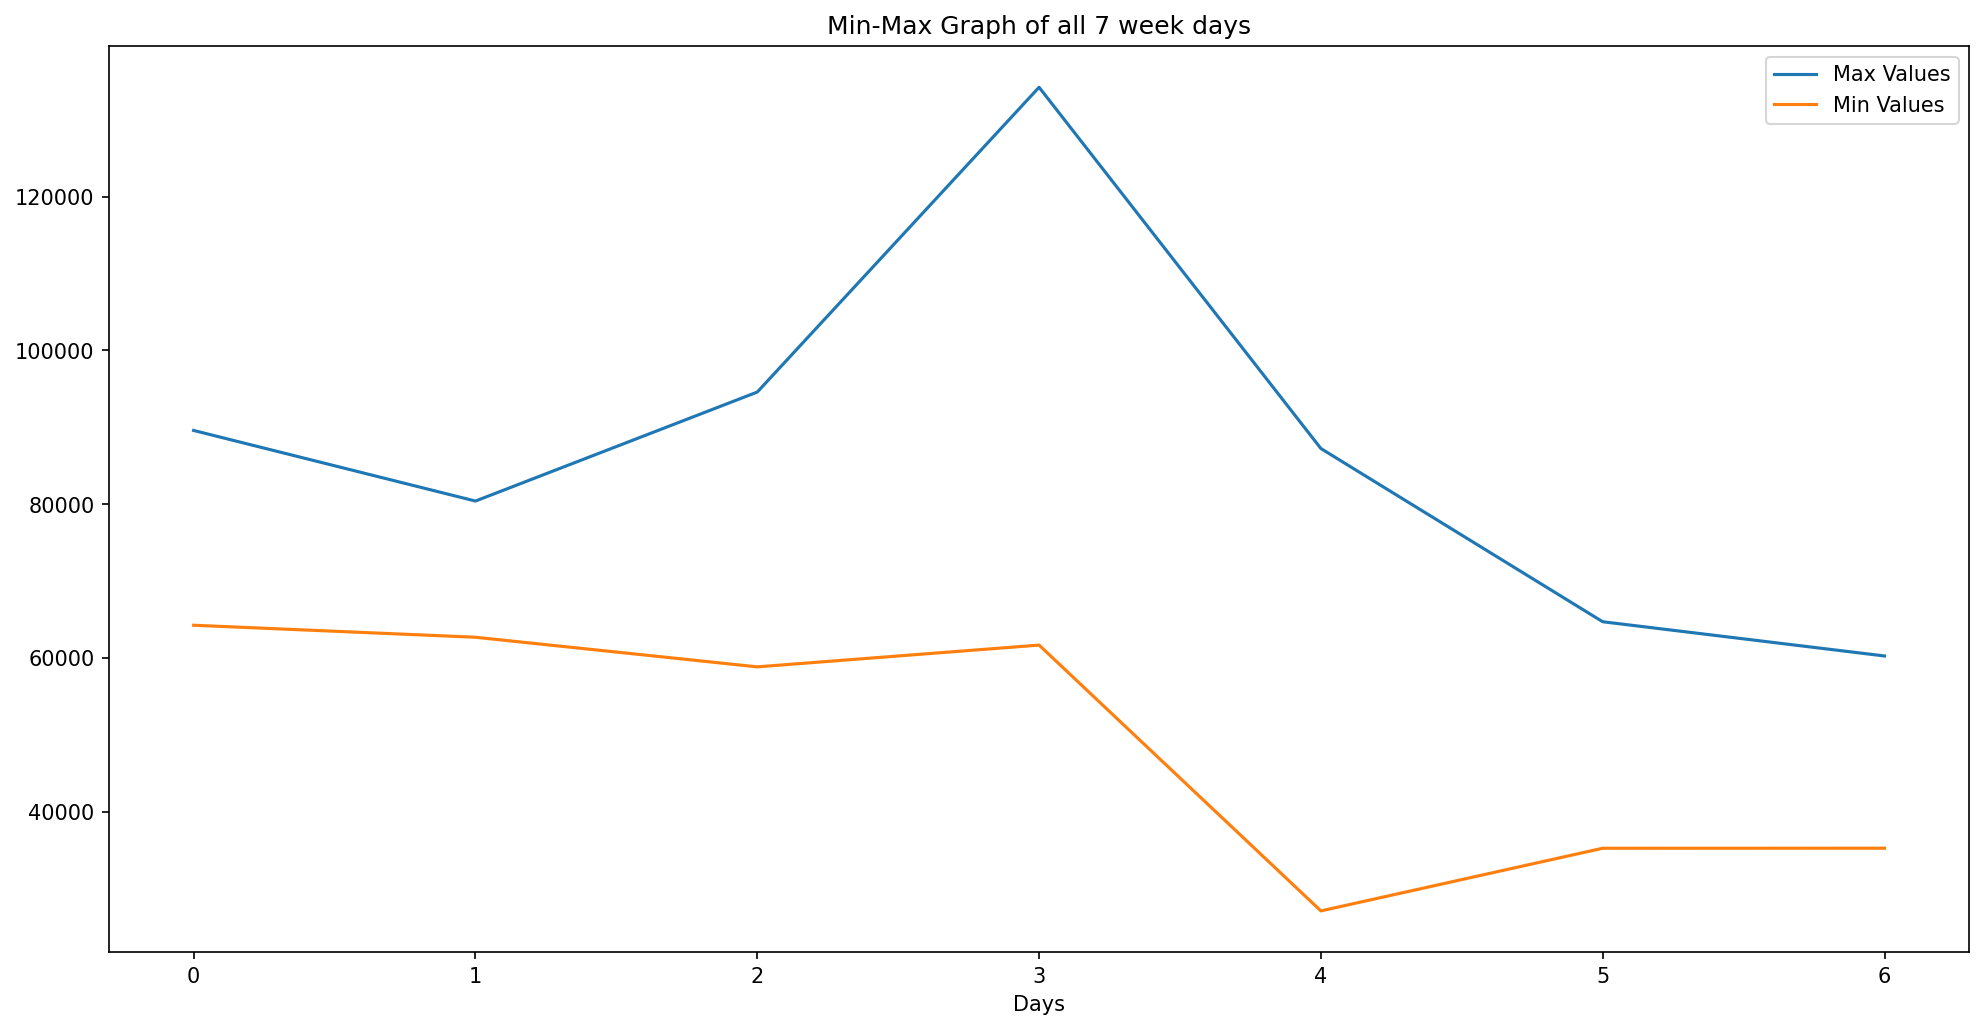

In [48]:
# c = sns.catplot(x='day', y='count', 
#                 data=daily_hosts_df, 
#                 kind='point')

#ranks = range(5,25)
# x=[5,10,15,20,25]
# y=[rmse_5,rmse_10,rmse_15,rmse_20,rmse_25]

#Maybe no ranks
# import tkinter
# import matplotlib
# import matplotlib.pyplot as plt
# matplotlib.use('TkAgg')




# %matplotlib inline: only draw static
# images in the notebook
import numpy as np
%matplotlib inline


# days_r =[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28]
#Creeaza o coloana cu numarul de zile

# c = daily_hosts_df.plot(x="day", y='total_reqs',kind='bar')

# maximals.plot(x="Mon-Sun", y='max(total_reqs)',kind='bar')

  
# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)

max_plot = maximals.toPandas()
max_plot['max(total_reqs)'].plot(x="Mon-Sun",label='Max Values',kind='line')

min_plot = minimals.toPandas()
min_plot['min(total_reqs)'].plot(x="Mon-Sun",label='Min Values',kind='line')



  
# using plot method to plot open prices.
# in plot method we set the label and color of the curve.
# tesla['Open'].plot(label='Tesla', color='orange')
# gm['Open'].plot(label='GM')
# ford['Open'].plot(label='Ford')
  
# adding title to the plot
plt.title('Min-Max Graph of all 7 week days')
  
# adding Label to the x-axis
plt.xlabel('Days')
  
# adding legend to the curve
plt.legend()

plt.savefig('Min-Max Graph.png')


# daily_hosts_df.savefig('filename.png')

# plt.plot(data=daily_hosts_df)

#plt.plot(5, rmse_5, 'bo-', label='Rank 5')
#plt.plot(10, rmse_10, 'rx-', label='Rank 10')
#plt.plot(15, rmse_15, 'g+-', label='Rank 15')
#plt.plot(20, rmse_20, 'c*-', label='Rank 20')
#plt.plot(25, rmse_25, 'r+-', label='Rank 25')


# plt.title('Ranks and their RMSEs')
# plt.xlabel('Day')
# plt.ylabel('Count')
# plt.legend()
# plt.show()
# plt.savefig("Output/Ranks_and_RMSEs_Final.png")


# plt.scatter('day', 'count' , data=daily_hosts_df)
# plt.xlabel('Day')
# plt.ylabel('Count')
# plt.show()


# plt.plot('day', 'count', data=daily_hosts_df)


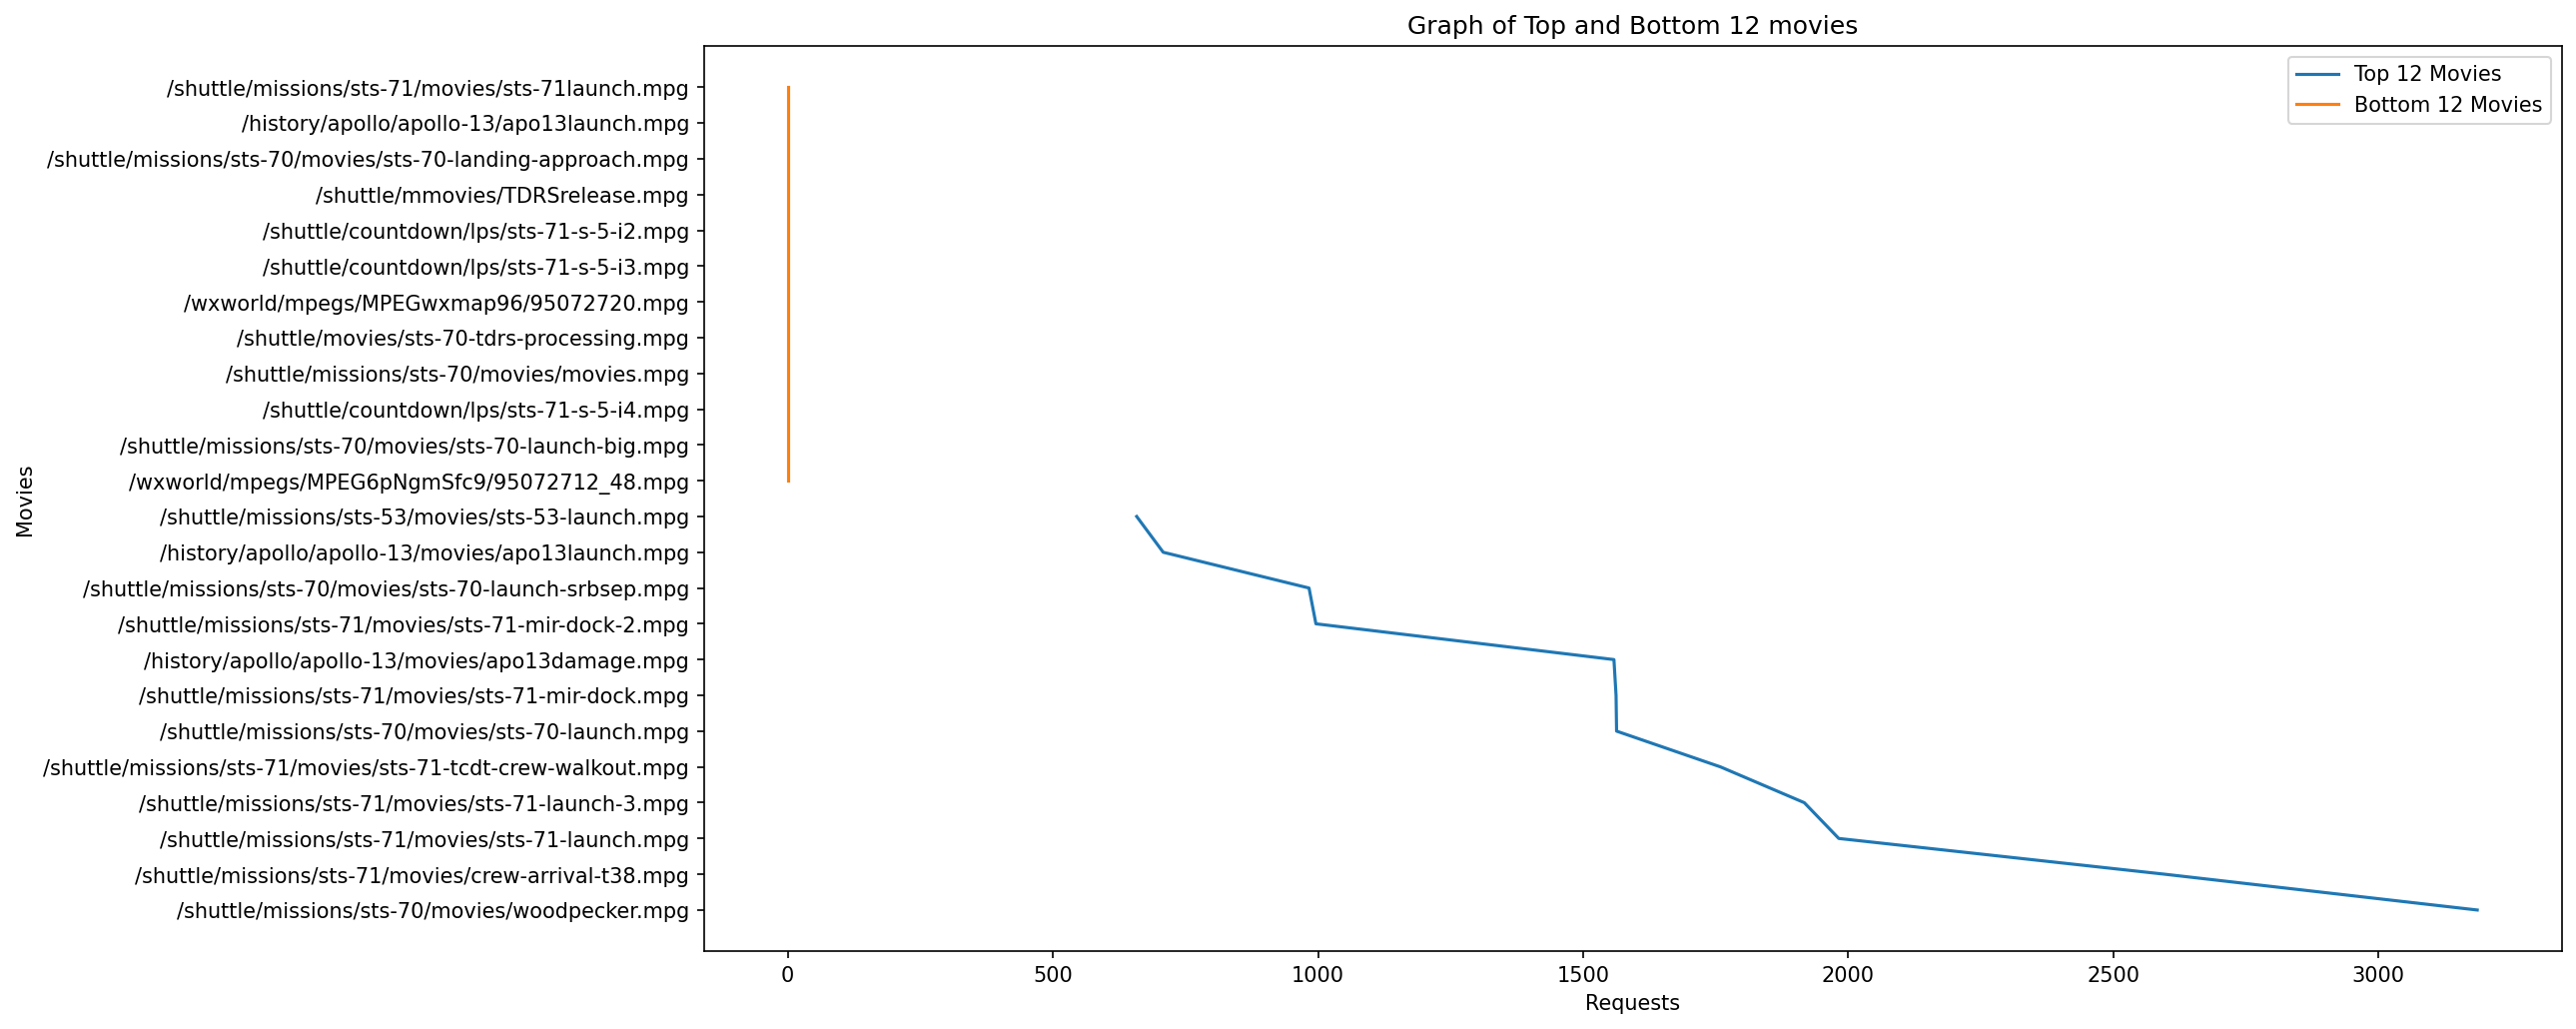

In [49]:
plt.figure(figsize=(16, 8), dpi=150)

top_plot = Top_mov_df.toPandas()
# top_plot['count'].plot(x="endpoint",label='Top 12 Movies',kind='line')

bot_plot = Bot_mov_df.toPandas()
# bot_plot['count'].plot(x="endpoint",label='Bottom 12 Movies',kind='line')

# fig = plt.figure(figsize=(16, 8), dpi=150)

# for frame in [top_plot, bot_plot]:
#     plt.plot(frame['count'], frame['endpoint'])
    
plt.plot(top_plot['count'], top_plot['endpoint'],label='Top 12 Movies')    
plt.plot(bot_plot['count'], bot_plot['endpoint'],label='Bottom 12 Movies')
# plt.xlim(0,8)
# plt.ylim(0,30)



# adding title to the plot
plt.title('Graph of Top and Bottom 12 movies')
  
# adding Label to the x-axis
plt.xlabel('Requests')
 
# adding Label to the y-axis
plt.ylabel('Movies') 
# adding legend to the curve
plt.legend()

# set the limits 
# plt.xlim([0, 3200]) 
# plt.ylim([0, 25])

plt.savefig('Movies Graph.png')

ALTE Chestii

In [50]:
content_size_summary_df = logFile.describe(['value'])
content_size_summary_df.toPandas()

,summary,value
0,count,1891715
1,mean,None
2,stddev,None
3,min,"***.novo.dk - - [11/Jul/1995:08:17:09 -0400] ""..."
4,max,zzz.pe.u-tokyo.ac.jp - - [13/Jul/1995:07:17:50...


In [51]:
# split into 5 columns using regex and split
data = logFile.withColumn('host', F.regexp_extract('value', '^(.*) - -.*', 1)) \
                .withColumn('timestamp', F.regexp_extract('value', '.* - - \[(.*)\].*',1)) \
                .withColumn('request', F.regexp_extract('value', '.*\"(.*)\".*',1)) \
                .withColumn('HTTP reply code', F.split('value', ' ').getItem(F.size(F.split('value', ' ')) -2).cast("int")) \
                .withColumn('bytes in the reply', F.split('value', ' ').getItem(F.size(F.split('value', ' ')) - 1).cast("int")).drop("value").cache()
data.show(10,False)

C:\Spark\spark-3.2.1-bin-hadoop2.7\python\pyspark\sql\column.py:322: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


+--------------------+--------------------------+------------------------------------------------------------+---------------+------------------+
|host                |timestamp                 |request                                                     |HTTP reply code|bytes in the reply|
+--------------------+--------------------------+------------------------------------------------------------+---------------+------------------+
|199.72.81.55        |01/Jul/1995:00:00:01 -0400|GET /history/apollo/ HTTP/1.0                               |200            |6245              |
|unicomp6.unicomp.net|01/Jul/1995:00:00:06 -0400|GET /shuttle/countdown/ HTTP/1.0                            |200            |3985              |
|199.120.110.21      |01/Jul/1995:00:00:09 -0400|GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0   |200            |4085              |
|burger.letters.com  |01/Jul/1995:00:00:11 -0400|GET /shuttle/countdown/liftoff.html HTTP/1.0                |304           

In [52]:
(logFile.agg(F.min(logFile['value']).alias('min_content_size'),
             F.max(logFile['value']).alias('max_content_size'),
             F.mean(logFile['value']).alias('mean_content_size'),
             F.stddev(logFile['value']).alias('std_content_size'),
             F.count(logFile['value']).alias('count_content_size'))
        .toPandas())

,min_content_size,max_content_size,mean_content_size,std_content_size,count_content_size
0,"***.novo.dk - - [11/Jul/1995:08:17:09 -0400] ""...",zzz.pe.u-tokyo.ac.jp - - [13/Jul/1995:07:17:50...,NaN,NaN,1891715
